# Approximate solvers for the Euler equations of gas dynamics

In this chapter we discuss approximate solvers for the one-dimensional Euler equations:

\begin{align}
    \rho_t + (\rho u)_x & = 0 \\
    (\rho u)_t + (\rho u^2 + p)_x & = 0 \\
    E_t + ((E+p)u)_x & = 0.
\end{align}

As in [Euler.ipynb](Euler.ipynb), we focus on the case of an ideal gas, for which the total energy is given by

\begin{align} \label{EA:EOS}
    E = \frac{p}{\gamma-1} + \frac{1}{2}\rho u^2.
\end{align}

## Roe solver

We first derive a Roe solver for the Euler equations, following the same approach as in [shallow_water_approximate.ipynb](shallow_water_approximate.ipynb).  Namely, we assume that $\hat{A} = f'(\hat{q})$ for some average state $\hat{q}$, and impose the condition of conservation:

\begin{align} \label{EA:cons}
    f'(\hat{q}) (q_r - q_l) & = f(q_r) - f(q_l).
\end{align}

We will need the following quantities:

\begin{align}
q & = \begin{pmatrix} \rho \\ \rho u \\ E \end{pmatrix}, \ \ \ \ \ \  f(q) = \begin{pmatrix} \rho u \\ \rho u^2 + p \\ H u \rho \end{pmatrix}, \\
f'(\hat{q}) & = \begin{pmatrix} 
                0 & 1 & 0 \\ 
                \frac{\gamma-3}{2}\hat{u}^2 & (3-\gamma)\hat{u} & \gamma-1 \\
                \frac{\gamma-1}{2}\hat{u}^3 - \hat{u}\hat{H} & \hat{H} - (\gamma-1)\hat{u}^2 & \gamma \hat{u} \end{pmatrix}.
\end{align}

Here $H = \frac{E+p}{\rho}$ is the enthalpy.  We have rewritten most expressions involving $E$ in terms of $H$ because it simplifies the derivation that follows.  We now solve (\ref{EA:cons}) to find $\hat{u}$ and $\hat{H}$.  It turns out that, for the case of a polytropic ideal gas, the average density $\hat{\rho}$ plays no role in the Roe solver.

The first equation of (\ref{EA:cons}) is an identity, satisfied independently of our choice of $\hat{q}$.  The second equation is (using (\ref{EA:EOS}))

\begin{align}
    \frac{\gamma-3}{2}\hat{u}^2 (\rho_r - \rho_l) + (3-\gamma)\hat{u}(\rho_r u_r - \rho_l u_l) \\ + (\gamma-1)\left( \frac{p_r-p_l}{\gamma-1} + \frac{1}{2}(\rho_r u_r^2 - \rho_l u_l^2) \right) & = \rho_r u_r^2 - \rho_l u_l^2 + p_r - p_l,
\end{align}

which simplifies to a quadratic equation for $\hat{u}$:

\begin{align} \label{EA:u_quadratic}
    (\rho_r - \rho_l)\hat{u}^2 - 2(\rho_r u_r - \rho_l u_l) \hat{u} + (\rho_r u_r^2 - \rho_l u_l^2) & = 0,
\end{align}

with roots

\begin{align}
    \hat{u}_\pm & = \frac{\rho_r u_r - \rho_l u_l \mp \sqrt{\rho_r \rho_l} (u_l - u_r)}{\rho_r - \rho_l} = \frac{\sqrt{\rho_r} u_r \pm \sqrt{\rho_l} u_l}{\sqrt{\rho_r}\pm\sqrt{\rho_l}}
\end{align}

Notice that this is identical to the Roe average of the velocity for the shallow water equations, if we replace the density $\rho$ with depth $h$.  As before, we choose the root $u_+$ since it is well defined for all values of $\rho_r, \rho_l$.

Next we find $\hat{H}$ by solving the last equation of (\ref{EA:cons}), which reads  
\begin{align}
    \left( \frac{\gamma-1}{2}\hat{u}^3 - \hat{u}\hat{H} \right)(\rho_r - \rho_l) \\ + \left( \hat{H} - (\gamma-1)\hat{u}^2 \right)(\rho_r u_r - \rho_l u_l) + \gamma \hat{u}(E_r - E_l) & = H_r u_r \rho_r - H_l u_l \rho_l.
\end{align}  
We can simplify this using the equality $\gamma E = \rho H + \frac{\gamma-1}{2}\rho u^2$ and solve for $\hat{H}$ to find  
\begin{align}
    \hat{H} & = \frac{\rho_r H_r (u_r - \hat{u}_+) - \rho_l H_l (u_l - \hat{u}_+)}{\rho_r u_r - \rho_l u_l - \hat{u}_\pm(\rho_r -\rho_l)} \\
    & = \frac{\rho_r H_r (u_r - \hat{u}_+) - \rho_l H_l (u_l - \hat{u}_+)}{\pm\sqrt{\rho_r \rho_l}(u_r-u_l)} \\
    & = \frac{\rho_r H_r - \rho_l H_l \mp\sqrt{\rho_r \rho_l}(H_r - H_l)}{\rho_r - \rho_l} \\
    & = \frac{\sqrt{\rho_r}H_r \pm \sqrt{\rho_l} H_l}{\sqrt{\rho_r}\pm\sqrt{\rho_l}}.
\end{align}  
Once more, we take the plus sign in the final expression for $\hat{H}$.

To implement the Roe solver, we also need the eigenvalues and eigenvectors of the averaged flux Jacobian $f'(\hat{q})$.  These are just the eigenvalues of the true Jacobian, evaluated at the averaged state:
\begin{align}
    \lambda_1 & = \hat{u} - \hat{c}, & \lambda_2 & = \hat{u} & \lambda_3 & = \hat{u} + \hat{c},
\end{align}  
\begin{align}
r_1 & = \begin{bmatrix} 1 \\ \hat{u}-\hat{c} \\ \hat{H}-\hat{u}\hat{c}\end{bmatrix} &
r_2 & = \begin{bmatrix} 1 \\ \hat{u} \\ \frac{1}{2}\hat{u}^2 \end{bmatrix} &
r_3 & = \begin{bmatrix} 1 \\ \hat{u}+\hat{c} \\ \hat{H}+\hat{u}\hat{c}\end{bmatrix}.
\end{align}
Here $\hat{c} = \sqrt{(\gamma-1)(\hat{H}-\hat{u}^2/2)}$.

Solving the system of equations
\begin{align}
q_r - q_l & = \sum_{p=1}^3 {\mathcal W}_p = \sum_{p=1}^3 \alpha_p r_p
\end{align}  
for the wave strengths gives
\begin{align}
    \alpha_2 & = \delta_1 + (\gamma-1)\frac{\hat{u}\delta_2 - \delta_3}{\hat{c}^2} \\
    \alpha_3 & = \frac{\delta_2 + (\hat{c}-\hat{u})\delta_1 - \hat{c}\alpha_2}{2\hat{c}} \\
    \alpha_1 & = \delta_1 - \alpha_2 - \alpha_3,
\end{align}  
where $\delta = q_r - q_l$.  We now have everything we need to implement the Roe solver.

In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'svg'
import numpy as np
from exact_solvers import euler
from utils import riemann_tools as rt
from ipywidgets import interact
from ipywidgets import widgets
State = euler.Primitive_State

In [3]:
def roe_averages(q_l, q_r, gamma=1.4):
    rho_sqrt_l = np.sqrt(q_l[0])
    rho_sqrt_r = np.sqrt(q_r[0])
    p_l = (gamma-1.)*(q_l[2]-0.5*(q_l[1]**2)/q_l[0])
    p_r = (gamma-1.)*(q_r[2]-0.5*(q_r[1]**2)/q_r[0])
    denom = rho_sqrt_l + rho_sqrt_r
    u_hat = (q_l[1]/rho_sqrt_l + q_r[1]/rho_sqrt_r)/denom
    H_hat = ((q_l[2]+p_l)/rho_sqrt_l + (q_r[2]+p_r)/rho_sqrt_r)/denom
    c_hat = np.sqrt((gamma-1)*(H_hat-0.5*u_hat**2))
    
    return u_hat, c_hat, H_hat
    
    
def Euler_roe(q_l, q_r, gamma=1.4):
    """
    Approximate Roe solver for the Euler equations.
    """
    
    rho_l = q_l[0]
    rhou_l = q_l[1]
    u_l = rhou_l/rho_l
    rho_r = q_r[0]
    rhou_r = q_r[1]
    u_r = rhou_r/rho_r
    
    u_hat, c_hat, H_hat = roe_averages(q_l, q_r, gamma)
    
    dq = q_r - q_l
    
    s1 = u_hat - c_hat
    s2 = u_hat
    s3 = u_hat + c_hat
    
    alpha2 = (gamma-1.)/c_hat**2 *((H_hat-u_hat**2)*dq[0]+u_hat*dq[1]-dq[2])
    alpha3 = (dq[1] + (c_hat - u_hat)*dq[0] - c_hat*alpha2) / (2.*c_hat)
    alpha1 = dq[0] - alpha2 - alpha3
    
    r1 = np.array([1., u_hat-c_hat, H_hat - u_hat*c_hat])
    r2 = np.array([1., u_hat, 0.5*u_hat**2])
    q_l_star = q_l + alpha1*r1
    q_r_star = q_l_star + alpha2*r2
    
    states = np.column_stack([q_l,q_l_star,q_r_star,q_r])
    speeds = [s1, s2, s3]
    wave_types = ['contact','contact', 'contact']
    
    def reval(xi):
        rho = (xi<s1)*states[0,0] + (s1<=xi)*(xi<s2)*states[0,1] + \
              (s2<=xi)*(xi<s3)*states[0,2] + (s3<=xi)*states[0,3]
        mom = (xi<s1)*states[1,0] + (s1<=xi)*(xi<s2)*states[1,1] + \
              (s2<=xi)*(xi<s3)*states[1,2] + (s3<=xi)*states[1,3]
        E = (xi<s1)*states[2,0] + (s1<=xi)*(xi<s2)*states[2,1] + \
              (s2<=xi)*(xi<s3)*states[2,2] + (s3<=xi)*states[2,3]
        return rho, mom, E
    
    return states, speeds, reval, wave_types

An implementation of this solver for use in Clawpack can be found [here](https://github.com/clawpack/riemann/blob/c0a41c664e9a13d35a113409dea92f3c87648d09/src/rp1_euler_with_efix.f90).  Recall that an exact Riemann solver for the Euler equations appears in [exact_solvers/euler.py](exact_solvers/euler.py).

### Examples

Let's compare the Roe approximation to the exact solution.  As a first example, we use the Sod shock tube.

In [8]:
def compare_solutions(left_state, right_state, solvers=['Exact','HLLE']):
    q_l = np.array(euler.primitive_to_conservative(*left_state))
    q_r = np.array(euler.primitive_to_conservative(*right))

    outputs = []
    states = {}

    for solver in solvers:
        if solver.lower() == 'exact':
            outputs.append(euler.exact_riemann_solution(q_l,q_r))
        if solver.lower() == 'hlle':
            outputs.append(Euler_hlle(q_l, q_r))
            states['hlle'] = outputs[-1][0]
        if solver.lower() == 'roe':
            outputs.append(Euler_roe(q_l, q_r))
            states['roe'] = outputs[-1][0]

    plot_function = \
        rt.make_plot_function([val[0] for val in outputs],
                              [val[1] for val in outputs],
                              [val[2] for val in outputs],
                              [val[3] for val in outputs],
                              solvers, layout='vertical',
                              variable_names=euler.primitive_variables,
                              derived_variables=euler.cons_to_prim,
                              vertical_spacing=0.15,
                              show_time_legend=True)
    
    interact(plot_function,
             t=widgets.FloatSlider(min=0,max=0.9,step=0.1,value=0.4));
    
    return states

In [9]:
left  = State(Density = 3.,
              Velocity = 0.,
              Pressure = 3.)
right = State(Density = 1.,
              Velocity = 0.,
              Pressure = 1.)

states = compare_solutions(left, right, solvers=['Exact','Roe'])

interactive(children=(FloatSlider(value=0.4, description='t', max=0.9), Output()), _dom_classes=('widget-inter…

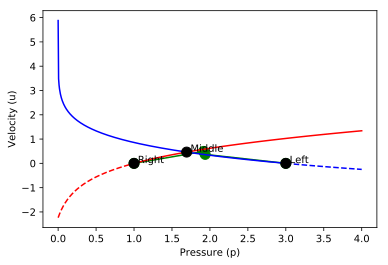

In [7]:
euler.phase_plane_plot(left, right, approx_states=states['roe'])

Recall that in the true solution the middle wave is a contact discontinuity and carries only a jump in the density. For that reason the three-dimensional phase space plot is generally shown projected onto the pressure-velocity plane as shown above: The two intermediate states in the true solution have the same pressure and velocity, and so are denoted by a single Middle state in the phase plane plot.  

The Roe solver, on the other hand, generates a middle wave that carries a jump in all 3 variables  and there are two green dots appearing in the plot above for the two middle states (though the pressure jump is quite small in this example).  For a Riemann problem like this one with zero initial velocity on both sides, the Roe average velocity must also be zero, so the middle wave is stationary; this is of course not typically true in the exact solution, even when $u_l=u_r=0$.

Here is a second example.  Experiment with the initial states to explore how the Roe solution compares to the exact solution.

In [ ]:
left  = State(Density = 0.1,
              Velocity = 0.,
              Pressure = 0.1)
right = State(Density = 1.,
              Velocity = 1.,
              Pressure = 1.)

states = compare_solutions(left, right, solvers=['Exact','Roe'])

In [ ]:
euler.phase_plane_plot(left, right, approx_states=states['roe'])

### Single-shock solution
Next we demonstrate the exactness property of the Roe solver by applying it to a case where the left and right states are connected by a single shock wave.

In [ ]:
M = 2.  # Mach number of the shock wave
gamma = 1.4
mu = 2*(M**2-1)/(M*(gamma+1.))
right = State(Density = 1.,
              Velocity = 0.,
              Pressure = 1.)
c_r = np.sqrt(gamma*right.Pressure/right.Density)

rho_l = right.Density * M/(M-mu)
p_l = right.Pressure * ((2*M**2-1)*gamma+1)/(gamma+1)
u_l = mu*c_r

left = State(Density = rho_l,
             Velocity = u_l,
            Pressure = p_l)

states = compare_solutions(left, right, solvers=['Exact','Roe'])

In [ ]:
euler.phase_plane_plot(left, right, approx_states=states['roe'])

It is evident that the solution consists of a single right-going shock.  The exact solution cannot be seen because it coincides exactly with the Roe solution.  The path of the shock in the first plot also cannot be seen since it is plotted under the path of the rightmost Roe solution wave.  The two solutions differ only in the wave speeds predicted for the other two waves, but since these waves have zero strength this makes no difference.

### Transonic rarefactions and an entropy fix
Here is an example of a Riemann problem whose solution includes a transonic 2-rarefaction:

In [ ]:
left  = State(Density = 0.1,
              Velocity = -2.,
              Pressure = 0.1)
right = State(Density = 1.,
              Velocity = -1.,
              Pressure = 1.)

states = compare_solutions(left, right, solvers=['Exact','Roe'])

Notice that in the exact solution, the right edge of the rarefaction travels to the right.  In the Roe solution, all waves travel to the left.  As in the case of the shallow water equations, here too this behavior can lead to unphysical solutions when this approximate solver is used in a numerical discretization.  In order to correct this, we can split the single wave into two when a transonic rarefaction is present, in a way similar to what is done in the shallow water equations.  We do not go into details here.

## HLLE Solver

Recall that an HLL solver uses only two waves with a constant state between them.  The Euler equations are our first example for which the number of waves in the true solution is larger than the number of waves in the approximate solution.  As one might expect, this leads to noticeable inaccuracy in solutions produced by the solver.

The left-going wave speed is chosen to be the minimum of the Roe speed for the 1-wave and the characterstic speed $\lambda^1$ in the left state $q_\ell$.  The right-going wave speed is chosen to be the maximum of the Roe speed for the 3-wave and the characteristic speed $\lambda^3$ in the right state $q_r$.  Effectively, this means that
\begin{align}
    s_1 & = \min(u_l - c_l, \hat{u}-\hat{c}) \\
    s_2 & = \max(u_r + c_r, \hat{u}+\hat{c})
\end{align}

Recall that once we have chosen these two wave speeds, conservation dictates the value of the intermediate state:  
\begin{align}  \label{SWA:hll_middle_state}
q_m = \frac{f(q_r) - f(q_l) - s_2 q_r + s_1 q_l}{s_1 - s_2}.
\end{align}

In [ ]:
def Euler_hlle(q_l, q_r, gamma=1.4):
    """HLLE approximate solver for the Euler equations."""
    
    rho_l = q_l[0]
    rhou_l = q_l[1]
    u_l = rhou_l/rho_l
    rho_r = q_r[0]
    rhou_r = q_r[1]
    u_r = rhou_r/rho_r
    E_r = q_r[2]
    E_l = q_l[2]
    
    u_hat, c_hat, H_hat = roe_averages(q_l, q_r, gamma)
    p_r = (gamma-1.) * (E_r - rho_r*u_r**2/2.)
    p_l = (gamma-1.) * (E_l - rho_l*u_l**2/2.)
    H_r = (E_r+p_r) / rho_r
    H_l = (E_l+p_l) / rho_l
    c_r = np.sqrt((gamma-1.)*(H_r-u_r**2/2.))
    c_l = np.sqrt((gamma-1.)*(H_l-u_l**2/2.))
    
    s1 = min(u_l-c_l,u_hat-c_hat)
    s2 = max(u_r+c_r,u_hat+c_hat)
    
    rho_m = (rhou_r - rhou_l - s2*rho_r + s1*rho_l)/(s1-s2)
    rhou_m = (rho_r*u_r**2 - rho_l*u_l**2 \
              + p_r - p_l - s2*rhou_r + s1*rhou_l)/(s1-s2)
    E_m = ( u_r*(E_r+p_r) - u_l*(E_l+p_l) - s2*E_r + s1*E_l)/(s1-s2)
    q_m = np.array([rho_m, rhou_m, E_m])
    
    states = np.column_stack([q_l,q_m,q_r])
    speeds = [s1, s2]
    wave_types = ['contact','contact']
    
    def reval(xi):
        rho  = (xi<s1)*rho_l + (s1<=xi)*(xi<=s2)*rho_m + (s2<xi)*rho_r
        mom  = (xi<s1)*rhou_l + (s1<=xi)*(xi<=s2)*rhou_m + (s2<xi)*rhou_r
        E  = (xi<s1)*E_l + (s1<=xi)*(xi<=s2)*E_m + (s2<xi)*E_r
        return rho, mom, E

    return states, speeds, reval, wave_types

### Examples

In [ ]:
left  = State(Density = 3.,
              Velocity = 0.,
              Pressure = 3.)
right = State(Density = 1.,
              Velocity = 0.,
              Pressure = 1.)
    
states = compare_solutions(left, right, solvers=['Exact','HLLE'])

In [ ]:
euler.phase_plane_plot(left, right, approx_states=states['hlle'])

### Preservation of positivity
Just as we saw in the case of the shallow water equations, the Roe solver (or any linearized solver) for the Euler equations fails to preserve positivity of the pressure and/or density in some situations.  Here is one example.

In [ ]:
left  = State(Density = 1.,
              Velocity = -5.,
              Pressure = 1.)
right = State(Density = 1.,
              Velocity = 1.,
              Pressure = 1.)

states = compare_solutions(left, right, solvers=['Exact', 'Roe'])

As we can see, in this example each Roe solver wave moves much more slowly than the leading edge of the corresponding true rarefaction.  In order to maintain conservation, this implies that the middle Roe state must have lower density than the true middle state.  This leads to a negative density.  Note that the velocity and pressure take huge values in the intermediate state.

The HLLE solver, on the other hand, guarantees positivity of the density and pressure.  Since the HLLE wave speed in the case of a rarefaction is always the speed of the leading edge of the true rarefaction, and since the HLLE solution is conservative, the density in a rarefaction will always be at least as great as that of the true solution.  This can be seen clearly in the example below.

In [ ]:
left  = State(Density = 1.,
                    Velocity = -10.,
                    Pressure = 1.)
right = State(Density = 1.,
                    Velocity = 1.,
                    Pressure = 1.)

states = compare_solutions(left, right, solvers=['Exact', 'HLLE']);

In [ ]:
euler.phase_plane_plot(left,right,approx_states=states['hlle'])